Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = ""
COLLABORATORS = ""

---

# Vaja 4: Robustno iskanje 2D objektov
Pri vaji bomo obravnavali postopek za iskanje oz. detekcijo oglišč in robov v 2D slikah. Oglišča so izraziti strukturni elementi slike oz. objektov na sliki in jih lahko uporabimo v aplikacijah kot so sledenje objektov v zaporednih posnetkih, določanje preslikave med različnimi pogledi enakega objekta, kot referečne točke za geometrijske meritve, za kalibracijo optičnih sistemov itd. Detektirane robove pa lahko nadgradimo za zaznavanje kompleksnejših objektov v 2D slikah.

Oglišče je definirano kot presečišče dveh robov, pri čemer rob v sliki v splošnem lahko opišemo kot veliko lokalno spremembo sivinske vrednosti. Robove lahko detektiramo na podlagi odvodov oz. gradientov slike. Prvi odvod za poljubno 2D funkcijo $f(x,y)$ zapišemo v obliki vektorja:

$$
	\nabla f(x,y) = \vec{g}(x,y) = 
	\left[ 
	\begin{array}{c} g_x (x, y) \\ g_y (x, y) \end{array} 
	\right] = \left[ 
	\begin{array}{c} \partial f(x, y) / \partial x \\ 
	\partial f(x, y) / \partial y  \end{array}
	\right]\,.
$$

Vektorska slika gradienta $\vec{g}(x,y)$ v vsaki točki $(x,y)$ vsebuje vektor, ki s  koordinatno osjo $x$ oklepa kot $\alpha$ in ima dolžino $G$:
$$
\alpha(x,y) = \mbox{arctan}\; \frac{g_y(x,y)}{g_x(x,y)}\,,\quad	G(x,y) = \sqrt{g_x^2(x,y) + g_y^2(x,y)}\,.
$$

Gradient $\vec{g}(x,y)$ kaže v smeri največje spremembe funkcije $f(x,y)$, torej pravokotno na dani rob v sliki. Komponenti gradienta $g_x (x,y)$ in $g_y (x,y)$, ki predstavljata parcialna odvoda, na digitalni sliki izračunamo z digitalnimi filtri, na primer s **Sobelovim jedrom**. Vektorsko sliko $\vec{g}(x,y)$ odvodov dobimo z dvema 2D diskretnima konvolucijama med vhodno sivinsko sliko in Sobelovima jedroma. 

In [1]:
import cv2 as cv
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from rvlib import showImage

<class 'numpy.ndarray'>
(400, 278, 3)
uint8


<IPython.core.display.Javascript object>


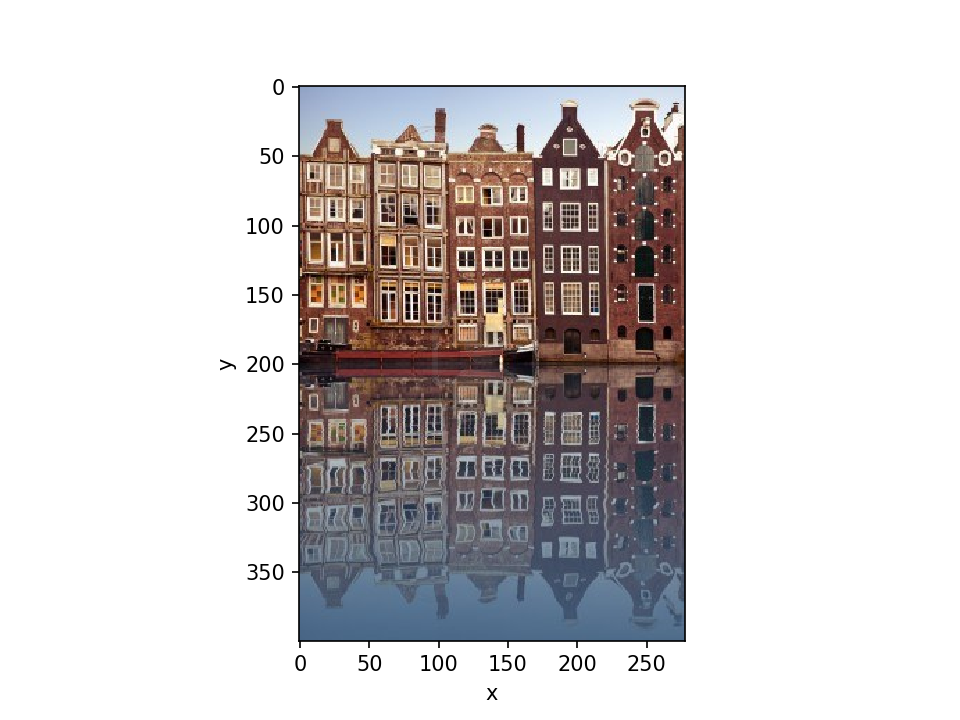

In [2]:
img = cv.imread('data/slika1.jpg')
print(type(img))
print(img.shape)
print(img.dtype)
#showImage(img)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
showImage(img_rgb)

In [ ]:
imgG = cv.imread('data/slika1.jpg', 0)#0 na konc -> sivinska
showImage(imgG)

sobelx = cv.Sobel(imgG, cv.CV_64F, 1, 0)#0/1 določa smer odvoda
sobely = cv.Sobel(imgG, cv.CV_64F, 0, 1)
showImage(sobelx)
showImage(sobely)

#magnituda gradienta
gradient_mag = np.sqrt(sobelx**2 + sobely**2)
showImage(gradient_mag)

gradient_dir = np.arctan(sobely/(sobelx + 1e-9))
gradient_dir[gradient_mag < np.median(gradient_mag)] = 0
showImage(gradient_dir)

![](images/RV4_Sobel_Harris.png)	  

## Harrisov detektor oglišč
Robovi v slikah imajo velik gradient v smeri pravokotno na rob, v ogliščih pa je gradient slike velik v več smereh, zato večina detektorjev oglišč temelji na primerjavi velikosti komponent gradienta v $x$ in $y$ smeri slike. V praksi se pogosto uporablja **Harrisov detektor oglišč**, pri katerem za vsako točko $(x,y)$ izračunamo lokalno strukturno matriko $M$:

$$
	M(x,y) = \left[
	\begin{array}{cc} A(x,y) & C(x,y) \\ C(x,y) & B(x,y)\end{array} \right] * N(x,y\;|\;\sigma) = 
	\left[
	\begin{array}{cc} g_x^2(x,y) & g_x(x,y) g_y(x,y) \\ g_x(x,y) g_y(x,y) & g_y^2(x,y)\end{array}
	\right] * N(x,y\;|\;\sigma)
$$

Komponente lokalne strukturne matrike $M$, tj. slike $A(x,y)$, $B(x,y)$ in $C(x,y)$ predstavljajo odvode slike, ki jih zgladimo z Gaussovim jedrom $N(x,y\;|\;\sigma)$ z uporabo diskretne 2D konvolucije ($*$). Kriterijsko funkcijo za detekcijo oglišč v vsaki točki slike $(x,y)$ določimo z analizo lastnih vrednosti $\lambda_1$ in $\lambda_2$ matrike $M$:

$$
\lambda_{1,2} = \frac{\mbox{trace}(M)}{2} \pm \sqrt{\left(\frac{\mbox{trace}(M)}{2}\right)^2 - \det(M) }\,,
$$

kjer sta $\mbox{trace}(\cdot)$ in $\det(\cdot)$ funkciji za sled in determinanto matrike $M$. Na področjih slike s konstantno sivinsko vrednostjo bo $M=0$ in $\lambda_1 = \lambda_2 = 0$, pri enakomerno naraščujoči sivinski vrednosti v eni smeri pa bo $\lambda_1>0$ in $\lambda_2=0$. Lastni vrednosti $\lambda_1$ in $\lambda_2$ torej kodirata izrazitost roba, pripadajoča lastna vektorja pa smer roba. V ogliščih je rob izrazit v smeri obeh lastnih vektorjev, lastni vrednosti sta veliki $|\lambda_{1,2}| \gg 0$ in velja $|\lambda_1 |\approx|\lambda_2|$, rob pa je tem bolj izrazit, čim manjša je razlika med lastnima vrednostima. Od tod sledi kriterijska funkcija za detekcijo oglišč:

$$
Q_H(x,y) = \lambda_1 \lambda_2 - \kappa (\lambda_1 + \lambda_2)^2 = \mbox{det}(M) - \kappa \left( \mbox{trace}(M) \right)^2\,.
$$

Parameter $\kappa$ določa občutljivost detektorja in ga izberemo na intervalu $[0,\tfrac{1}{4}]$. Točke roba detektiramo kot lokalne maksimume v $Q_H(x,y)$, nadalje pa detektirana oglišča prečistimo z upragovljanjem $Q(x,y)>T_{min}$, kjer je $T_{min}$ običajno na intervalu od $10^4$ do $10^6$.

In [ ]:
imgG = cv.imread('data/slika1.jpg', 0)

sobelx = cv.Sobel(imgG, cv.CV_64F, 1, 0)
sobely = cv.Sobel(imgG, cv.CV_64F, 0, 1)

gx2 = sobelx**2
gy2 = sobely**2
gxy = sobelx * sobely

traceM = gx2 + gy2
detM = gx2 * gy2 - 2*gxy
lastna_vrednost1 = traceM/2 + np.sqrt((traceM/2)**2 - detM)
lastna_vrednost2 = traceM/2 - np.sqrt((traceM/2)**2 - detM)
#na mesta kjer dobimo NaN damo nulo
lastna_vrednost1[np.isnan(lastna_vrednost1)] = 0
lastna_vrednost2[np.isnan(lastna_vrednost2)] = 0

showImage(lastna_vrednost1 * lastna_vrednost2)
showImage((lastna_vrednost1 + lastna_vrednost2)**2)
corners = lastna_vrednost1 * lastna_vrednost2 - 0.1 * (lastna_vrednost1 + lastna_vrednost2)**2
showImage(corners)

## Cannyev detektor robov
Zaznavanje robov v slikah je eden izmed pomembnejših postopkov na področju obdelave in analize slik, **Cannyev detektor robov** pa je eden izmed najpogosteje uporabljanih tovrstnih postopkov. Algoritem Cannyevega detektorja lahko povzamemo s štirimi osnovnimi koraki:

* Glajenje slike z Gaussovim filtrom
* Izračun slike velikosti in smeri gradienta
* Odstranjevanje nemaksimalnih vrednosti
* Dvojno upragovljanje in povezovanje robov

![](images/RV_5_SLO_Canny.png)	  

Za glajenje in določanje slik gradienta lahko uporabimo poljubni digitalni filter. V sliki gradientov dobimo okoli robov širša področja ojačitve, ki jih moramo zožiti oz. odstraniti, zato da ohranimo prave robove slike. Odstranjevanje nemaksimalnih vrednosti naredimo tako, da postavimo na nič vrednosti tistih slikovnih elementov, ki nimajo maksimalnih vrednosti v diskretni smeri gradienta (0$^{\circ}$,45$^{\circ}$,90$^{\circ}$ in 135$^{\circ}$) oz. katerih sosednji slikovni elementi imajo v smeri gradienta večje vrednosti. V zadnjem koraku postopka izvedemo še upragovljanje slike robov in povezovanje robnih točk. Upragovljanje izvedemo z dvema pragoma. Z zgornjim pragom $T_H$ določimo izrazite robne točke $r_H (x,y)$, ki jih bomo neposredno zadržali. To so tiste točke, ki imajo magnitudo gradienta $G(x,y)>T_H$. S spodnjim pragom $T_L$ pa določimo neizrazite robne točke $r_L (x,y)$, ki jih bomo obdržali za postopek povezovanja robov. Povezovanje izrazitih robov $r_H (x,y)$ izvedemo tako, da vsako  sosednjo točko, ki pripada $r_L (x,y)$ ($T_L<G(x,y)\leq T_H$) vključimo v množico končnih robnih točk. 

## Houghova transformacija
Med postopke iskanje objektov na sliki spada tudi iskanje premic oz. črt. Učinkovit postopek iskanja premic na sliki temelji na **Houghovi transformaciji**. Predpostavimo, da imamo binarno sliko robov $r(x,y)$. Skozi poljubno izbrano robno točko $(x_i,y_i )$ lahko potegnemo poljubno število premic oblike:

$$
	y_i=ax_i+b.
$$

Isto enačbo lahko zapišemo v prostoru parametrov $(a,b)$, kjer sta koordinati robne točke $x_i$ in $y_i$ parametra premice:

$$
    b=-x_i a+y_i.
$$

![](images/RV_5_SLO_hough_parameter_space.png)

Za neko drugo robno točko $(x_j, y_j)$ dobimo v prostoru parametrov $(a, b)$ še eno premico, ki se v neki točki $(a', b')$ seka s premico, ki pripada $(x_i, y_i)$. Parametra $(a', b')$ določata enačbo premice v prostoru slike $r(x, y)$, ki gre skozi točki $(x_i, y_i)$ in $(x_j, y_j)$. Če za vse robne točke v sliki vnesemo pripadajočo premico v parametrični prostor, potem lahko poiščemo premice oz. črte z detekcijo vrhov v parametričnem prostoru.

Pri tovrstnemu zapisu enačbe premice naletimo na problem pri navpičnih premicah, pri katerih gre parameter $a\rightarrow \inf$, s tem pa tudi velikost parametričnega prostora $(a,b)$. Temu se lahko izognemu z zapisom premice v polarnih koordinatah $(r,\varphi)$:

$$
    x \cos  \varphi + y \sin \varphi = r
$$

Za navpično premico ($\varphi = 0^\circ$) določa $r$ presečišče z $x$ osjo, za vodoravno premico ($\varphi = 90^\circ$) pa določa $r$ presečišče premice z $y$ osjo. V polarnem prostoru prostoru $(r,\varphi)$ vsaka sinusna krivulja $x_i \cos  \varphi + y_i \sin \varphi = r$ predstavlja množico premic, ki gredo v prostoru slike $(x,y)$ skozi točko $(x_i,y_i )$. Presečišče dveh ali večih sinusnih krivulj $(r',\varphi')$ določa parametra premice v prostoru $(x,y)$.
 
![](images/RV_5_SLO_hough_accumulator.png)	  
 
Prostor parametrov $(r,\varphi)$ lahko enostavno diskretiziramo, in sicer $0 \leq \varphi < \pi$ ter  $-r_{diag} \leq r \leq r_{diag}$. Pri tem je $r_{diag}=\sqrt{M^2+N^2 }/2$ in $M,N$ sta višina in širina slike $r(x,y)$, referenčna točka pa je center slike $(M/2,N/2)$.  Diskretiziran prostor imenujemo akumulator $A(r_n,\varphi_m )$, ki ga najprej postavimo na $0$, nato pa za vsako robno točko $(x_i,y_i )$ in za vsako možno diskretno vrednost $0 \leq \varphi_m<\pi$ izračunamo ustrezno diskretno vrednost parametra $r_n$, nato pa vrednost akumulatorja v celici $(r_n, \varphi_m )$ povečamo za $1$. Premice, ki predstavljajo robne točke slike, določimo tako, da poiščemo tiste celice akumulatorja $A(r_n,\varphi_m )$, ki imajo dovolj velike in lokalno največje vrednosti.

![](images/RV_5_SLO_hough_transform.png)	  

## OpenCV
**OpenCV** je knjižnica programskih funkcij, ki se izvajajo v realnem času, namenjenim potrebam računalniškega vida. Knjižnica vsebuje osnovna orodja za obdelavo slik, torej tudi tista za robustno iskanje 2D objektov, s katerimi se bomo seznanili na današnjih vajah. 

Pri vaji boste uporabili OpenCV funkcije za izračun odziva Harrisovega detektorja oglišč ter funkcije za prečiščevanje seznama detektiranih točk. Spoznali boste tudi način kako z analizo lastnih vrednosti strukturne matrike $M$ načrtati filter za poudarjanje podolgovatih struktur v 2D slikah. Cannyjev detektor boste uporabili za izločenje robov iz slike, na podlagi robov pa boste s pomočjo Houghove transformacije poiskali vse premice na sliki.

## Naloge
1. Uporabite OpenCV funkcijo za detekcijo robov v vhodni sivinski sliki `iImage` z uporabo Cannyjevega algoritma: 
```python
edges = Canny( iImage, threshold1, threshold2 )
```
kjer praga `threshold1` in `threshold2` določata območja povezovanja robov. Preizkusite različne vrednosti pragov na slikah `slika1.jpg`, `slika2.jpg` in `slika3.jpg`. 

In [ ]:
img = cv.imread('data/slika1.jpg')
imgG = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
edges = cv.Canny(imgG, 10, 200)
showImage(imgG)
showImage(edges)

In [ ]:
img = cv.imread('data/slika2.jpg')
imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
imgG = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
edges = cv.Canny(imgG, 10, 50)#verdnosti trešholda so odvisne od tega kakšne vrednosti dobimo pri gradientu
showImage(imgRGB)
showImage(edges)

2. S pomočjo Houghove transformacije na že izračunanih robovih v sliki `slika3.jpg` poiščite vse premice skozi najmočnejše črte na sliki:
```python
lines = HoughLines( iImage, rho, theta, threshold)
```
kjer polje `lines` vsebuje pare parametrov $r$ in $\varphi$, ki določata položaj premice na sliki. Prikažite vse premice na sliki.

In [ ]:
img = cv.imread('data/slika3.jpg')
imgG = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
edges = cv.Canny(imgG, 75, 151)
showImage(imgG)
showImage(edges)

In [ ]:
# HoughLines(image, rho, theta, threshold) → lines
# image – 8-bit, single-channel binary source image. The image may be modified by the function.
# rho – Distance resolution of the accumulator in pixels.
# theta – Angle resolution of the accumulator in radians.
# threshold – Accumulator threshold parameter. Only those lines are returned that get enough votes

img = cv.imread('data/slika3.jpg')
#uporablji slajderje
lines = cv.HoughLines(edges, 0.5, 0.5*np.pi/180, 100)#vrne radij in kot!
#zvečanjem akumulatroja se poveča občutljivost za detekcijo linije + resolucija se poslabša (linije ne nalegajo natančno)
for line in lines:
    for rho, theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*a)
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*a)
        
        cv.line(img, (x1, y1), (x2, y2), (0, 0, 255), 1)
        
rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

showImage(rgb)

3. Uporabite OpenCV funkcijo `cornerHarris` za izračun odziva Harrisovega detektorja oglišč na sliki `slika1.jpg`:
```python
corners = cornerHarris( iImage, blockSize, ksize, k )
```
kjer je `k` občutljivost detektorja oglišč ($\kappa$), `blockSize` pa standardna deviacija Gaussove funkcije za glajenje odziva. Funkcija vrne sliko `corners`, ki predstavlja odziv detektorja oglišč. Preizkusite delovanje funkcije za različne vrednosti parametrov `k` in `blockSize`. Uporabite upragovljanje za določitev območij visokih odzivov. 

>#### Dokumentacija
```python
cv2.cornerHarris(src, blockSize, ksize, k[, dst[, borderType]]) → dst
```
Parameters:
* src – Input single-channel 8-bit or floating-point image.
* dst – Image to store the Harris detector responses. It has the type CV_32FC1 and the same size as src.
* blockSize – Neighborhood size (see the details on cornerEigenValsAndVecs() ).
* ksize – Aperture parameter for the Sobel() operator.
* k – Harris detector free parameter. See the formula below.
* borderType – Pixel extrapolation method. See borderInterpolate().

<IPython.core.display.Javascript object>


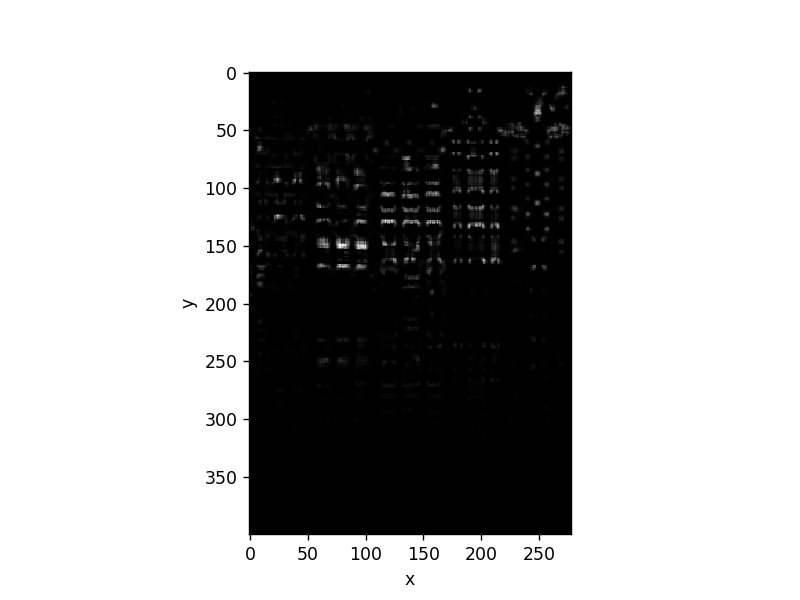

<IPython.core.display.Javascript object>


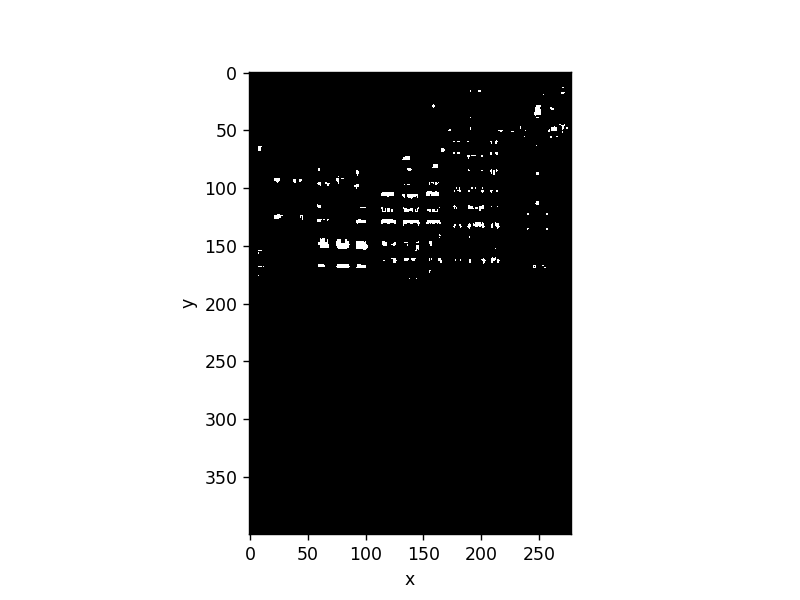

In [5]:
img = cv.imread('data/slika1.jpg')
imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
imgG = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# showImage(imgRGB)
corners = cv.cornerHarris(imgG, 5, 3, 1/16)
corners[corners < 0] = 0
corners = (corners - np.min(corners)) / (np.max(corners) - np.min(corners))
showImage(corners)

showImage(255 * (corners > 0.2).astype('uint8'))

In [ ]:
def findLocalMax(iImage, iThreshold=None):
    dy, dx = iImage.shape
    oLocalMax = []
    for y in range(1, dy - 1): #not gremo za en piksel, da lahko celotno oklico robnih pikslov gledamo
        for x in range(1, dx - 1):
            cval = iImage[y, x]
            if iThreshold is not None:
                if cval < iThreshold:
                    continue
            gx, gy = np.meshgrid([x - 1, x, x + 1], 
                                 [y - 1, y, y + 1], sparse=False)#indeksi oklice
            gx = gx.flatten()
            gy = gy.flatten()
            
            cvaldiff = iImage[gy, gx] - cval#3x3 array
            cvaldiff[int(np.floor(len(gy)/2))] = -1#damo ga na -1 zato da nam pol ne mot oLocalMax.max izracuna
            
            if cvaldiff.max() < 0:
                oLocalMax.append((x, y))#v vektor max-ov appendamo indekse točke maksimuma
    return np.array(oLocalMax)

In [ ]:
# Test funkcije findLocalMax
oLocalMax = findLocalMax(corners, corners.max() * 0.1) 
showImage(imgRGB, 'Originalna slika')
plt.plot(oLocalMax[:,0], oLocalMax[:,1], 'o', markersize=5.0)

4. Lokalni maksimumi v odzivu Harrisovega detektorja predstavljajo detektirana oglišča na vhodni sliki. Lokalni maksimumi v 2D polju so tiste točke, v katerih je vrednost večja od vrednosti v sosednjih 8 elementih slike.
```python
pts = goodFeaturesToTrack(iImage, maxCorners, qualityLevel, 
                          minDistance, None, None, blockSize, 
                          useHarrisDetector, k)
```
Polje `pts` vsebuje koordinate detektiranih oglišč.

>#### Dokumentacija
```python
cv2.goodFeaturesToTrack(image, maxCorners, qualityLevel, minDistance[, corners[, mask[, blockSize[, useHarrisDetector[, k]]]]]) → corners
```
Parameters:	
* image – Input 8-bit or floating-point 32-bit, single-channel image.
* corners – Output vector of detected corners.
* maxCorners – Maximum number of corners to return. If there are more corners than are found, the strongest of them is returned.
* qualityLevel – Parameter characterizing the minimal accepted quality of image corners. The parameter value is multiplied by the best corner quality measure, which is the minimal eigenvalue (see cornerMinEigenVal() ) or the Harris function response (see cornerHarris() ). The corners with the quality measure less than the product are rejected. For example, if the best corner has the quality measure = 1500, and the qualityLevel=0.01 , then all the corners with the quality measure less than 15 are rejected.
* minDistance – Minimum possible Euclidean distance between the returned corners.
* mask – Optional region of interest. If the image is not empty (it needs to have the type CV_8UC1 and the same size as image ), it specifies the region in which the corners are detected.
* blockSize – Size of an average block for computing a derivative covariation matrix over each pixel neighborhood. See cornerEigenValsAndVecs() .
* useHarrisDetector – Parameter indicating whether to use a Harris detector (see cornerHarris()) or cornerMinEigenVal().
* k – Free parameter of the Harris detector.

>The function finds the most prominent corners in the image or in the specified image region, as described in [Shi94]:
1. Function calculates the corner quality measure at every source image pixel using the cornerMinEigenVal() or cornerHarris() .
2. Function performs a non-maximum suppression (the local maximums in 3 x 3 neighborhood are retained).
3. The corners with the minimal eigenvalue less than $\texttt{qualityLevel} \cdot \max_{x,y} qualityMeasureMap(x,y)$ are rejected.
4. The remaining corners are sorted by the quality measure in the descending order.
5. Function throws away each corner for which there is a stronger corner at a distance less than maxDistance.

>The function can be used to initialize a point-based tracker of an object.

<IPython.core.display.Javascript object>


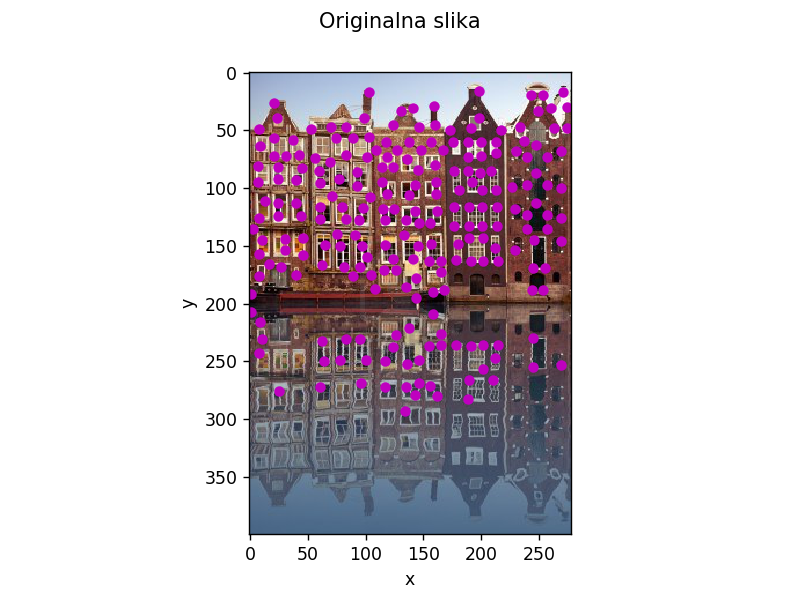

In [6]:
# nalozimo sliko kot grayscale
imgG = cv.imread('data/slika1.jpg', 0)
maxCorners = 500
qualityLevel = 0.03
minDistance = 10
blockSize = 5 #velikost gausovga jedrca
useHarrisDetector = True
k = 1/16
corners = cv.goodFeaturesToTrack(imgG, 
                                 maxCorners, 
                                 qualityLevel, 
                                 minDistance,
                                 None,
                                 None,
                                 blockSize,
                                 useHarrisDetector,
                                 k)
corners = np.squeeze(corners)
showImage(imgRGB, 'Originalna slika')
plt.plot(corners[:,0],corners[:,1], 'om', markersize=5.0)

In [ ]:
imgCorners = np.array(imgRGB)

for x,y in corners:
    cv.circle(imgCorners, (x,y), 1, 255, -1)

showImage( imgCorners, 'Originalna slika' )

In [ ]:
eigen = cv.cornerEigenValsAndVecs(imgG, 11, 3)
print(eigen.shape)
iKappa = 0.04
oQH = eigen[:,:,0]*eigen[:,:,1] - iKappa*((eigen[:,:,0]+eigen[:,:,1])**2)
showImage(oQH)

<IPython.core.display.Javascript object>


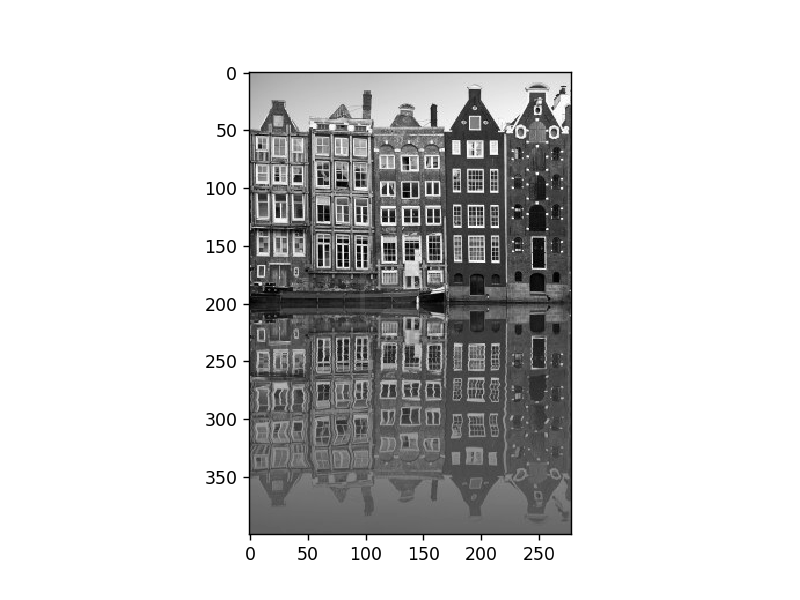

interactive(children=(FloatSlider(value=2.5000000000000004, description='beta', max=5.0, min=0.1), Output()), …

<function __main__.update>

In [8]:
from ipywidgets import interact

sigma = 0.1
ksize = (15, 15)
blurred = cv.GaussianBlur(imgG, ksize, sigma)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
img = ax.imshow(blurred, cmap='gray')

def update(beta):
    blurred = cv.GaussianBlur(imgG, ksize, beta)
    img.set_data(blurred)#update podatkov na sliki
    fig.canvas.draw()

interact(update, beta = (0.1, 5, 0.1))